# Reproducing Movie Tag classification model in PyTorch

This notebook is my "getting started" notebook for PyTorch, and I will work with our dataset on Movie Tag extraction. https://doi.org/10.1109/ACCESS.2019.2963535

## 1 Load the dataset

We can load datasets from folders with ImageFolder. Later, we can split the dataset in test, val, train with random_split.

### 1.1 Auxiliary functions for dataset

Let's define a function to load the dataset:                                          

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np

# what: loads the movie tag dataset from a folder, and a dictionary with the label names
# input: folder, image size, and verbosity
# return: data object
# example: data = load_movie_dataset('./data/Movie',[128,128])
def load_movietag_dataset(folder,im_size=[128,128],verbose=True):
    data = datasets.ImageFolder(
         folder,
         transform=transforms.Compose([transforms.ToTensor(),transforms.Resize(im_size)]),
         target_transform=transforms.Lambda(lambda y: torch.zeros(51, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
         )
    
    if verbose:
        print(f"Loaded {len(data)} samples")

    return data

/home/miguel/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's define a function to do the splits of the dataset:

In [2]:
# what: split the dataset in train test
# input: dataset object, the percentage for train, verbosity
# return: data objects for train an val
# example: train, val = data_splits(data,0.8)
def data_splits(dataset,tr_percent=0.8,verbose=True):
    total_size = len(data)
    train_size = int(np.floor(tr_percent*total_size))
    test_size  = total_size-train_size
    
    # we can split the dataset randomnly like this
    train, test = torch.utils.data.random_split(data, [train_size, test_size])
    
    if verbose:
        print(f"Splitted the dataset with {len(data)} samples. Train: {len(train)}, Test: {len(test)}")
    
    return train, test
    

One function to check the status of the dataset (randomnly show images)

In [3]:
import matplotlib.pyplot as plt

def print_random_samples(data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item() # random number, get item because it's a random tensor
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(data.classes[torch.argmax(label).item()])
        plt.axis("off")
        plt.imshow(transforms.ToPILImage()(img)) #, cmap="rgb")
    plt.show()


The following function creates the data loaders (the iterators over the dataset).

In [4]:
from torch.utils.data import DataLoader

def create_data_loader(train,test,batch_size=32,cuda_avail=False):
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=cuda_avail)
    test_dataloader = DataLoader(test, batch_size=batch_size*2, num_workers=8, pin_memory=cuda_avail) 
    return train_dataloader, test_dataloader

### 1.2 Auxiliary functions for model

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model(model):
    print(model)
    print(f"Number of Parameters: {count_parameters(model)}")

## 2. Quick look to the dataset

We will load the dataset and print a couple of random samples

Loaded 34664 samples


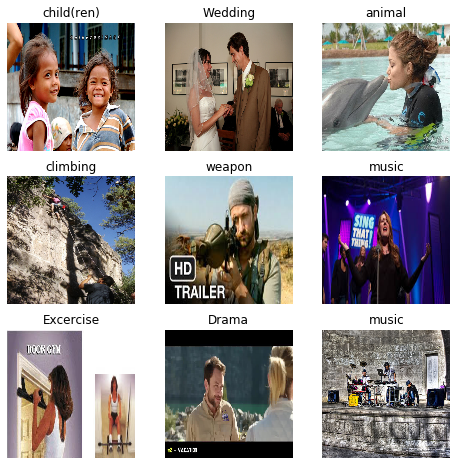

In [6]:
data = load_movietag_dataset('./data/Movie')
print_random_samples(data)

## 3. Model definition

Next, we define the model class

In [7]:
from torch import nn

class MovieNet1(nn.Module):
    def __init__(self):
        super(MovieNet1, self).__init__()      ## required!    
        self.conv_stack = nn.Sequential(       ## This is a block of convolutions
            nn.Conv2d(3,32,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64,64,kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64,96,kernel_size=3, stride=2),
            nn.ReLU()           
        )
        self.dense_stack = nn.Sequential (   # This is the classifier
            nn.Flatten(),
            nn.Linear(7776,100),
            nn.ReLU(),
            nn.Linear(100,51),
            #nn.Softmax(dim=1)            # In Pytorch, softmax is embedded in the crossEntropy loss function
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.dense_stack(x)
        return x
        #logits = self.linear_relu_stack(x)
        #return logits

## 4. Training the model

### 4.1. Check CUDA installation

Let's check if we have CUDA on the server

In [8]:
cuda_enabled = torch.cuda.is_available()

device = "cuda" if cuda_enabled else "cpu"
print(f"Using {device} device")

torch.cuda.get_device_name(torch.cuda.current_device())

Using cuda device


'NVIDIA GeForce RTX 2080'

### 4.2. Load the dataset and create data loaders
Load the dataset and split in test and train

In [9]:
image_res=[128,128]  # input resolution to the model

# load the dataset
data = load_movietag_dataset('./data/Movie',image_res)

# split the data
train, test = data_splits(data,0.8)

Loaded 34664 samples
Splitted the dataset with 34664 samples. Train: 27731, Test: 6933


Show random samples

Create the data loaders for train and test

In [10]:
train_loader, test_loader = create_data_loader(train,test,batch_size=32,cuda_avail=cuda_enabled)

# For debugging purposes, I will get the first samples
train_features, train_labels = next(iter(train_loader))

### 4.3 Create the model

In [33]:
#Test the model. This is good to know the output shape of the network
model = MovieNet1()

In [12]:
print_model(model)

MovieNet1(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2))
    (8): ReLU()
  )
  (dense_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7776, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=51, bias=True)
  )
)
Number of Parameters: 894563


In [34]:
# send the model to the GPU
if cuda_enabled:
    model = model.cuda()

### 4.4. Optimizer and loss function


In [14]:
from torch.optim import Adam, SGD

learning_rate = 0.001

# defining the optimizer (receives the parameters of the model!)
optimizer = Adam(model.parameters(), lr=learning_rate)

# defining the loss function, in this caase cross entropy loss (it has softmax embedded!)
loss_func = nn.CrossEntropyLoss()

In [15]:
# send the loss to the GPU
if torch.cuda.is_available():
    loss_func = loss_func.cuda()

In [16]:
def accuracy(pred,y):
    return (pred.argmax(1)==y.argmax(1)).float().mean().item()

In [17]:
def validation(model,dataloader):
    model.eval()
    loss = accu = 0
    for X, Y in dataloader: 
        X=X.cuda()
        Y=Y.cuda()
        
        with torch.no_grad():
            pred = model(X)
        
            loss += loss_func(pred, Y)
            accu += accuracy(pred,Y)
    model.train()
    return loss.item()/len(dataloader), accu/len(dataloader)

### 4.5 Train loop

In [18]:
import torch
from torch.utils.tensorboard import SummaryWriter


In [25]:
import time
epochs = 20

def train(model, traindl, valdl, epochs=20, tensorboard=False, printstep=100):

    # number of samples in training, TODO what if data augmentation?
    size = len(traindl.dataset) 

    print (f"number of samples {size}")
    print (f"number of epochs {epochs}")

    tb_writer = None
    if tensorboard:           # create the log dir
        tb_writer = SummaryWriter()
        
    t0 = t1 = time.time()     # our timers

    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        loss_train = acc_train = 0
        
        for batch, (X, Y) in enumerate(traindl):  # for each sample
            # send the data to the GPU
            X=X.cuda()
            Y=Y.cuda()

            # FORWARD            
            pred = model(X)           # Compute prediction of the network            
            loss = loss_func(pred, Y) # Calculate the loss

            # BACKWARD        
            loss.backward()        # the backpropagation phase, from loss to all recorded tensors        
            optimizer.step()       # one step of the optimizer        
            optimizer.zero_grad(set_to_none=True)  # gradients are accumulated in PyTorch, need to zero them.        
            #for param in model.parameters():  # this loop is similar to using set_to_none=True in zero_grad
            #    param.grad = None
            
            loss, current = loss.item(), batch * len(X) # calculate loss and acc
            acc = accuracy(pred,Y)

            if tensorboard:  # write to tensorboard
                tb_writer.add_scalar("Loss/train", loss, current+epoch*size)
                tb_writer.add_scalar("Accuracy/train", acc, current+epoch*size)

            if (printstep > 0 and batch > 0 and batch % printstep == 0):                    
                print(f"loss: {loss:>7f} accuracy: {acc:>7f}  [{current:>5d}/{size:>5d}/{epoch:>2d}] | elapsed time: {time.time() - t1:>4f} s")
                t1 = time.time()  # timer for batches
            
            loss_train += loss
            acc_train += acc


        loss_train = loss_train / len(traindl)  # mean of loss and acc for train
        acc_train  = acc_train / len(traindl)
        print(f"Train: loss: {loss_train:>7f} accuracy: {acc_train:>7f} | elapsed time: {time.time() - t0:>4f} s")          
        t0 = time.time()
        
        loss, acc = validation(model,valdl)  # validation phase
        print(f"Validation: loss: {loss:>7f} accuracy: {acc:>7f} | elapsed time: {time.time() - t0:>4f} s")  

        if tensorboard:   # write validation to tensorboard
            tb_writer.add_scalar("Loss/val", loss, epoch)
            tb_writer.add_scalar("Accuracy/val", acc, epoch)
        
        t0 = time.time()  # timer for epochs and validation
    
    if tensorboard:
        tb_writer.flush()
        tb_writer.close()

In [35]:
train(model,train_loader,test_loader,printstep=200)

number of samples 27731
number of epochs 20
epoch: 0
loss: 3.953976 accuracy: 0.000000  [ 6400/27731/ 0] | elapsed time: 8.833319 s
loss: 3.935975 accuracy: 0.000000  [12800/27731/ 0] | elapsed time: 8.095489 s
loss: 3.937154 accuracy: 0.000000  [19200/27731/ 0] | elapsed time: 8.322067 s
loss: 3.942182 accuracy: 0.000000  [25600/27731/ 0] | elapsed time: 8.357576 s
Train: loss: 3.933167 accuracy: 0.005756 | elapsed time: 36.227646 s
Validation: loss: 3.932649 accuracy: 0.007167 | elapsed time: 7.940853 s
epoch: 1
loss: 3.940166 accuracy: 0.000000  [ 6400/27731/ 1] | elapsed time: 19.063963 s
loss: 3.948839 accuracy: 0.031250  [12800/27731/ 1] | elapsed time: 8.229775 s
loss: 3.926300 accuracy: 0.000000  [19200/27731/ 1] | elapsed time: 8.132082 s
loss: 3.924887 accuracy: 0.000000  [25600/27731/ 1] | elapsed time: 8.475079 s
Train: loss: 3.933175 accuracy: 0.005731 | elapsed time: 36.029606 s
Validation: loss: 3.932649 accuracy: 0.007167 | elapsed time: 7.875485 s
epoch: 2
loss: 3.9251

In [31]:
# Attempt to make batches asynchronously
def train_2(model, traindl, valdl, epochs=20, tensorboard=False, printstep=100):

    # number of samples in training, TODO what if data augmentation?
    size = len(traindl.dataset) 

    print (f"number of samples {size}")
    print (f"number of epochs {epochs}")

    tb_writer = None
    if tensorboard:           # create the log dir
        tb_writer = SummaryWriter()
        
    t0 = t1 = time.time()     # our timers

    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        loss_train = acc_train = 0
        
        train_iter = iter(traindl)
        X, Y = next(train_iter)
        X = X.cuda()
        Y = Y.cuda()
        
        for batch in range(len(traindl)):
        #for batch, (X, Y) in enumerate(traindl):  # for each sample       

            # FORWARD            
            pred = model(X)           # Compute prediction of the network            
            loss = loss_func(pred, Y) # Calculate the loss
            
            if batch+1 < size:
                X, Y = next(train_iter)
                X = X.cuda(non_blocking=True)
                Y = Y.cuda(non_blocking=True)            

            # BACKWARD        
            loss.backward()        # the backpropagation phase, from loss to all recorded tensors        
            optimizer.step()       # one step of the optimizer        
            optimizer.zero_grad(set_to_none=True)  # gradients are accumulated in PyTorch, need to zero them.        
            #for param in model.parameters():  # this loop is similar to using set_to_none=True in zero_grad
            #    param.grad = None
            
            loss, current = loss.item(), batch * len(X) # calculate loss and acc
            acc = accuracy(pred,Y)

            if tensorboard:  # write to tensorboard
                tb_writer.add_scalar("Loss/train", loss, current+epoch*size)
                tb_writer.add_scalar("Accuracy/train", acc, current+epoch*size)

            if (printstep > 0 and batch > 0 and batch % printstep == 0):                    
                print(f"loss: {loss:>7f} accuracy: {acc:>7f}  [{current:>5d}/{size:>5d}/{epoch:>2d}] | elapsed time: {time.time() - t1:>4f} s")
                t1 = time.time()  # timer for batches
            
            loss_train += loss
            acc_train += acc


        loss_train = loss_train / len(traindl)  # mean of loss and acc for train
        acc_train  = acc_train / len(traindl)
        print(f"Train: loss: {loss_train:>7f} accuracy: {acc_train:>7f} | elapsed time: {time.time() - t0:>4f} s")          
        t0 = time.time()
        
        loss, acc = validation(model,valdl)  # validation phase
        print(f"Validation: loss: {loss:>7f} accuracy: {acc:>7f} | elapsed time: {time.time() - t0:>4f} s")  

        if tensorboard:   # write validation to tensorboard
            tb_writer.add_scalar("Loss/val", loss, epoch)
            tb_writer.add_scalar("Accuracy/val", acc, epoch)
        
        t0 = time.time()  # timer for epochs and validation
    
    if tensorboard:
        tb_writer.flush()
        tb_writer.close()

In [32]:
train_2(model,train_loader,test_loader,printstep=200)

number of samples 27731
number of epochs 20
epoch: 0
loss: 0.787191 accuracy: 0.031250  [ 6400/27731/ 0] | elapsed time: 9.441792 s
loss: 0.300180 accuracy: 0.093750  [12800/27731/ 0] | elapsed time: 8.471194 s
loss: 0.384051 accuracy: 0.062500  [19200/27731/ 0] | elapsed time: 7.849438 s
loss: 0.405563 accuracy: 0.000000  [25600/27731/ 0] | elapsed time: 7.950860 s


RuntimeError: The size of tensor a (32) must match the size of tensor b (19) at non-singleton dimension 0